# Time-Series with ARIMA and LSTM

### Goal

Predict the number of disasters or their types for the upcoming months/years: Provide forecasts for disaster management planning.


Download the [dataset here](https://www.kaggle.com/datasets/fema/federal-disasters/data).

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*cuInit.*")

## Load Data

In [2]:
df = pd.read_csv("../data/database.csv")
df.head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes


In [3]:
df.shape

(46185, 14)

In [4]:
df["Declaration Number"].is_unique

False

In [5]:
df["Declaration Type"].is_unique

False

In [6]:
diff_date = df["Declaration Date"] != df["Start Date"]
diff_date.value_counts()

True     36458
False     9727
Name: count, dtype: int64

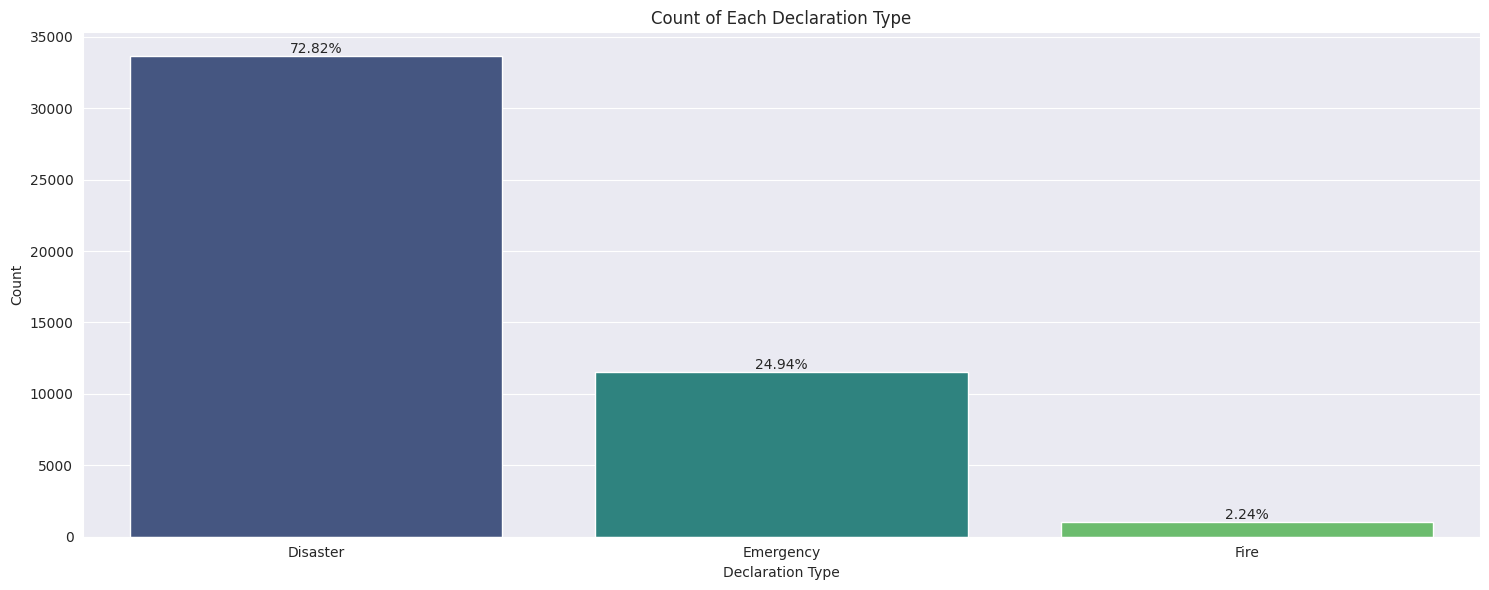

In [7]:
# Get the value counts of 'Declaration Type'
declaration_type_counts = df['Declaration Type'].value_counts()

# Calculate the percentage of each declaration type
total_count = declaration_type_counts.sum()
percentages = (declaration_type_counts / total_count) * 100

# Plot the value counts using seaborn barplot
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=declaration_type_counts.index, y=declaration_type_counts.values, hue=declaration_type_counts.index, palette='viridis')

# Add labels and title
plt.xlabel('Declaration Type')
plt.ylabel('Count')
plt.title('Count of Each Declaration Type')

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.tight_layout();


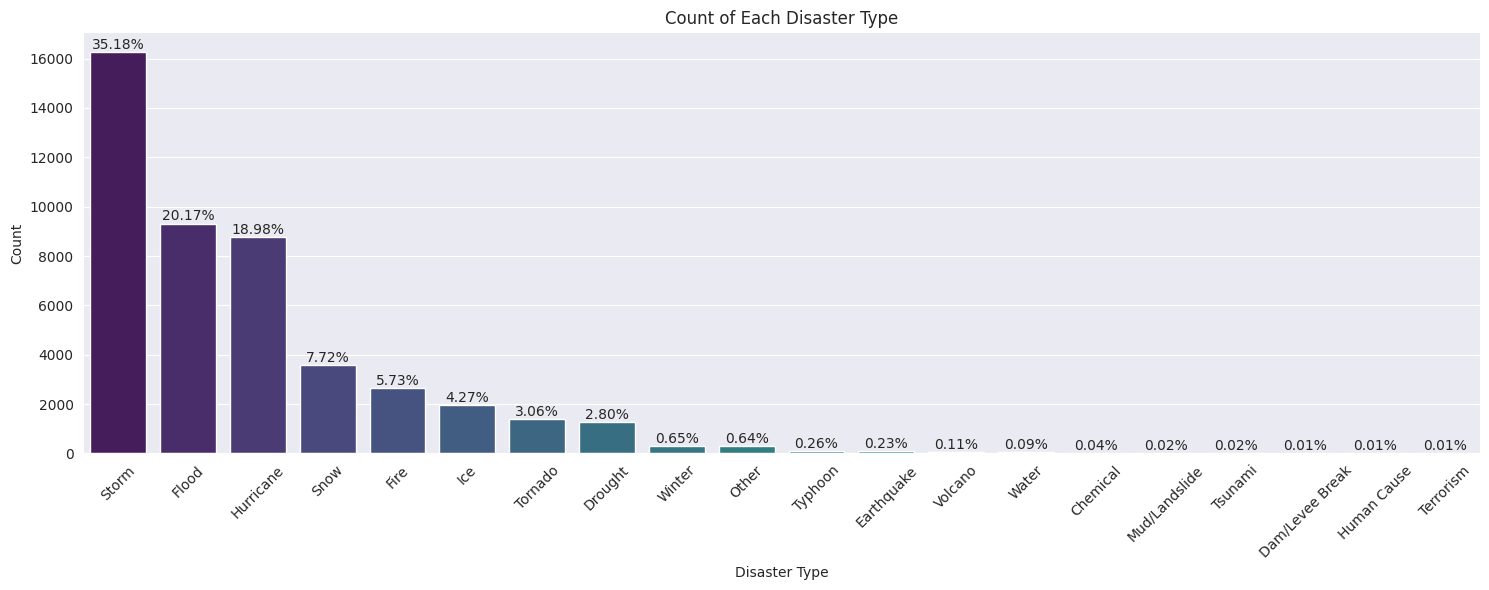

In [8]:
# Get the value counts of 'Disaster Type'
disaster_type_counts = df['Disaster Type'].value_counts()

# Calculate the percentage of each disaster type
total_count = disaster_type_counts.sum()
percentages = (disaster_type_counts / total_count) * 100

# Plot the value counts using seaborn barplot
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=disaster_type_counts.index, y=disaster_type_counts.values, hue=disaster_type_counts.index, palette='viridis')

# Add labels and title
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.title('Count of Each Disaster Type')

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

# Display the plot
plt.xticks(rotation=45)  
plt.tight_layout();

In [9]:
# Convert dates to datetime and set index
df['Declaration Date'] = pd.to_datetime(df['Declaration Date'])
df.set_index('Declaration Date', inplace=True)

# Aggregate disaster counts by year
disaster_counts_df = df.resample('ME').size().reset_index(name='disaster_count')

# Set 'Declaration Date' as index for the resampled data
disaster_counts_df.set_index('Declaration Date', inplace=True)

# Ensure the time series data is from the 'count' column
time_series_data = disaster_counts_df['disaster_count']

# Ensure the frequency is set correctly (monthly data in this case)
time_series_data = time_series_data.asfreq('ME')

In [10]:
disaster_counts_df.head()

,disaster_count
Declaration Date,
1953-05-31,3
1953-06-30,6
1953-07-31,1
1953-08-31,0
1953-09-30,0


In [11]:
time_series_data.head()

Declaration Date
1953-05-31    3
1953-06-30    6
1953-07-31    1
1953-08-31    0
1953-09-30    0
Freq: ME, Name: disaster_count, dtype: int64

In [12]:
are_equal = time_series_data.equals(disaster_counts_df)
print(are_equal)

False


In [13]:
# Convert the Series to DataFrame
time_series_data_df = time_series_data.to_frame()

# Now compare both DataFrames
are_equal = disaster_counts_df.equals(time_series_data_df)
print(are_equal)

True


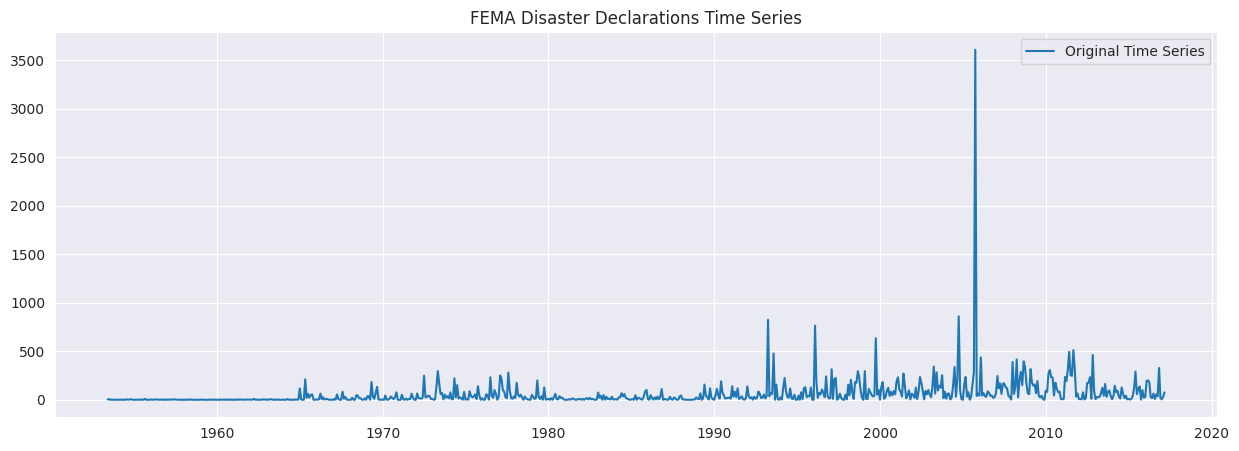

In [14]:
# Plot the time series data
plt.figure(figsize=(15, 5))
plt.plot(time_series_data, label='Original Time Series')
plt.title('FEMA Disaster Declarations Time Series')
plt.legend()
plt.show()

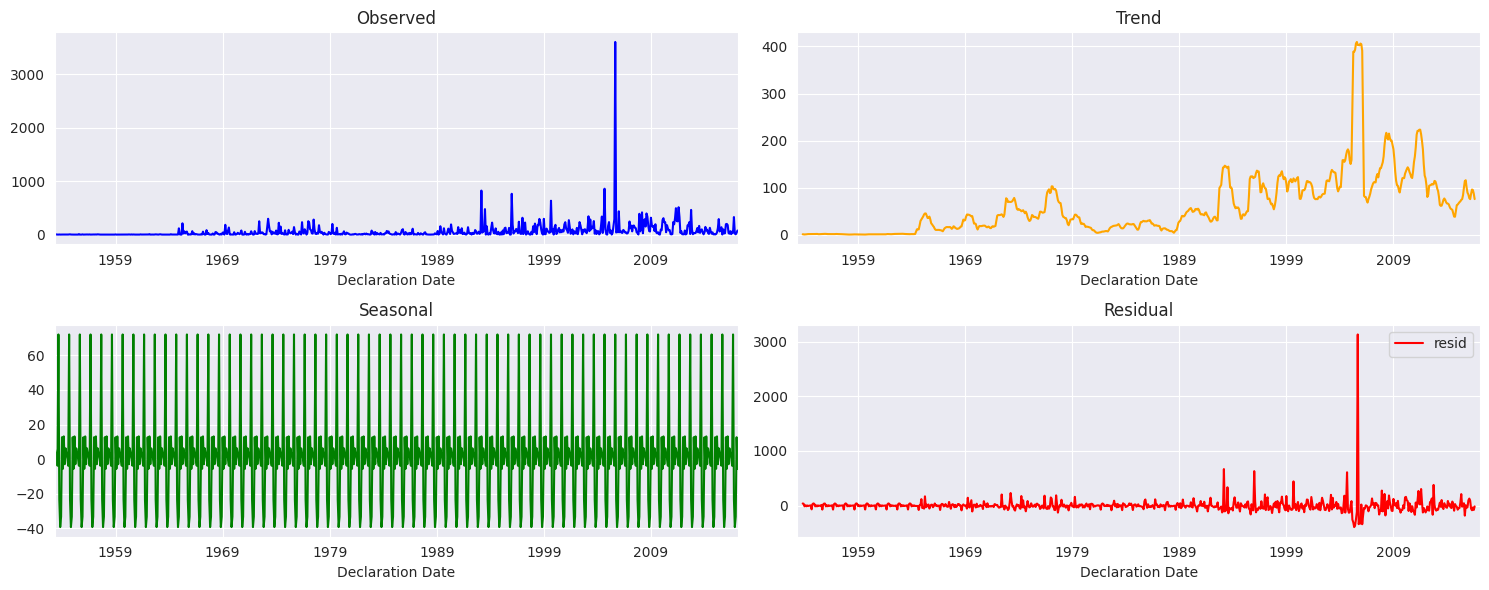

In [15]:
# Decompose the time series
decompose_result = seasonal_decompose(time_series_data, model='additive')

fig, axes = plt.subplots(2, 2, figsize=(15, 6))

# Plot each component in a separate subplot
decompose_result.observed.plot(ax=axes[0, 0], title='Observed', color='blue')
decompose_result.trend.plot(ax=axes[0, 1], title='Trend', color='orange')
decompose_result.seasonal.plot(ax=axes[1, 0], title='Seasonal', color='green')
decompose_result.resid.plot(ax=axes[1, 1], title='Residual', color='red')

plt.legend()
plt.tight_layout();

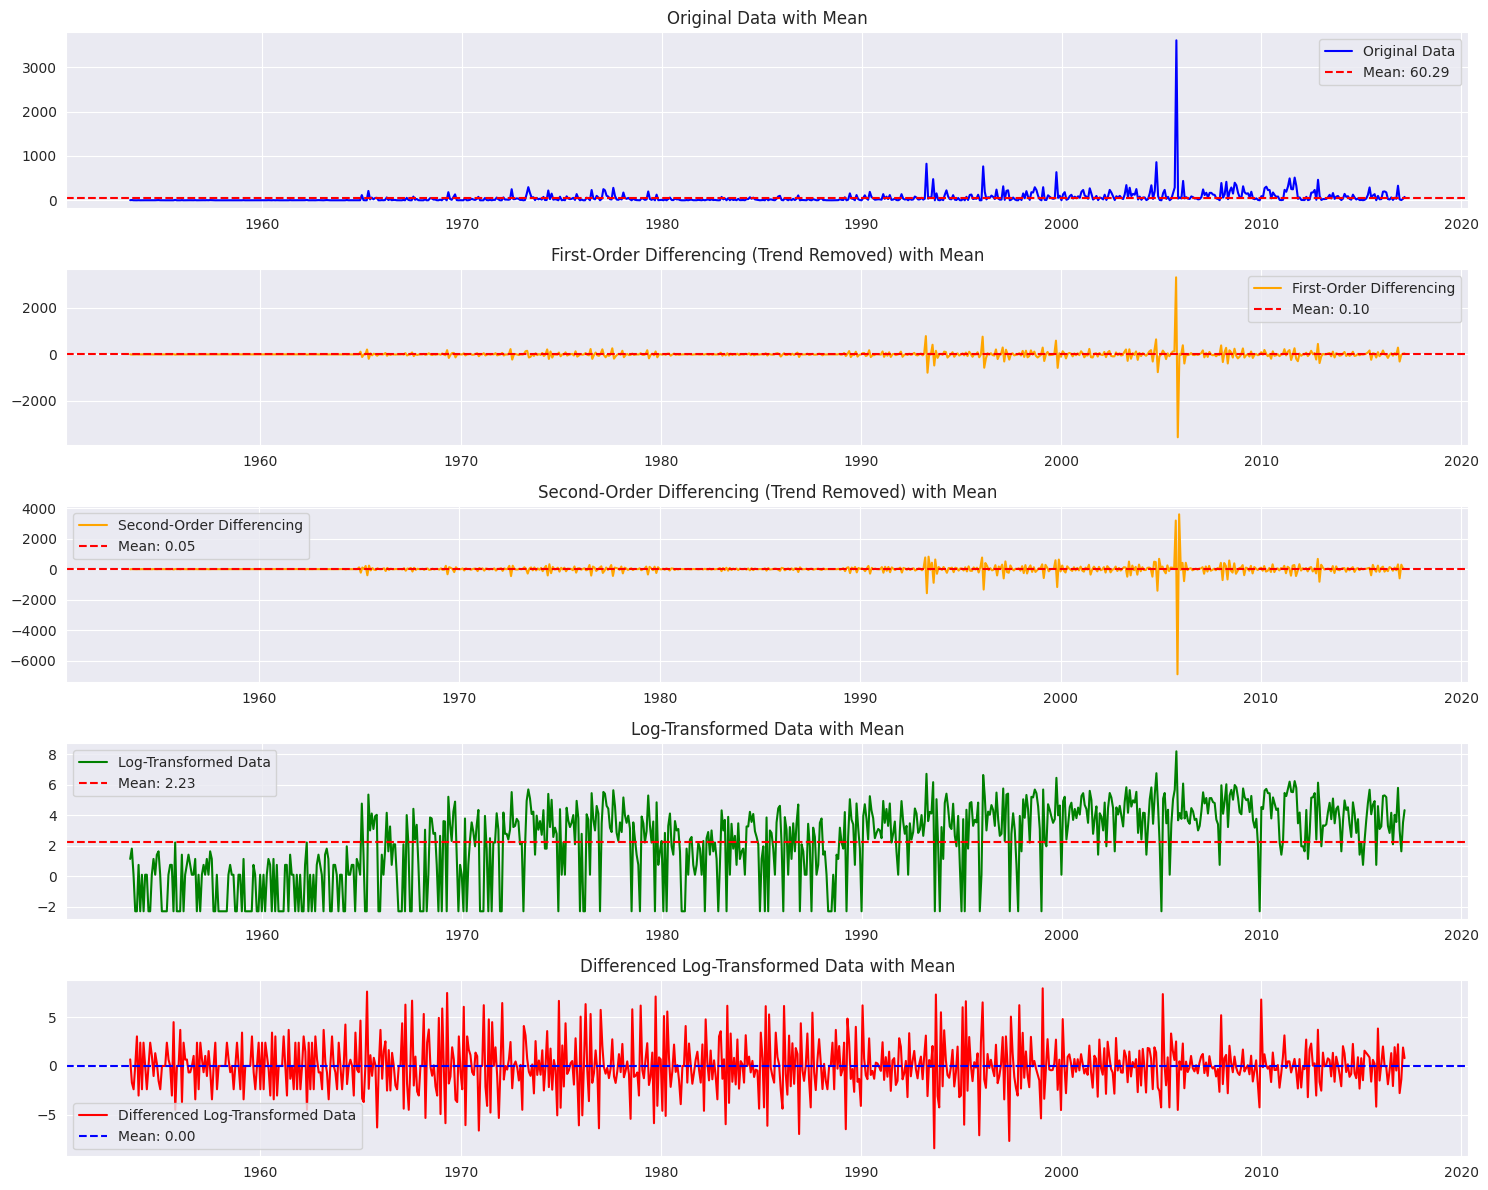

In [16]:
# First Differenced Data
first_differenced = time_series_data.diff().dropna()
# Second Differenced Data
second_differenced = first_differenced.diff().dropna()
# Log-Transformed Data
log_transformed = np.log(time_series_data + .1).replace(-np.inf, np.nan).dropna()
# Differenced Log-Transformed Data
log_diff = log_transformed.diff().dropna()

# Calculate means for each transformation
original_mean = time_series_data.mean()
first_differenced_mean = first_differenced.mean()
second_differenced_mean = second_differenced.mean()
log_transformed_mean = log_transformed.mean()
log_diff_mean = log_diff.mean()

# Plot the Original Data with mean
plt.figure(figsize=(15, 12))
plt.subplot(5, 1, 1)
plt.plot(time_series_data, label="Original Data", color='blue')
plt.axhline(original_mean, color='red', linestyle='--', label=f"Mean: {original_mean:.2f}")
plt.title("Original Data with Mean")
plt.legend()

# Plot the First Differenced Data with mean
plt.subplot(5, 1, 2)
plt.plot(first_differenced, label="First-Order Differencing", color='orange')
plt.axhline(first_differenced_mean, color='red', linestyle='--', label=f"Mean: {first_differenced_mean:.2f}")
plt.title("First-Order Differencing (Trend Removed) with Mean")
plt.legend()

# Plot the Second Differenced Data with mean
plt.subplot(5, 1, 3)
plt.plot(second_differenced, label="Second-Order Differencing", color='orange')
plt.axhline(second_differenced_mean, color='red', linestyle='--', label=f"Mean: {second_differenced_mean:.2f}")
plt.title("Second-Order Differencing (Trend Removed) with Mean")
plt.legend()

# Plot the Log-Transformed Data with mean
plt.subplot(5, 1, 4)
plt.plot(log_transformed, label="Log-Transformed Data", color='green')
plt.axhline(log_transformed_mean, color='red', linestyle='--', label=f"Mean: {log_transformed_mean:.2f}")
plt.title("Log-Transformed Data with Mean")
plt.legend()  

# Plot the Differenced Log-Transformed Data with mean
plt.subplot(5, 1, 5)
plt.plot(log_diff, label="Differenced Log-Transformed Data", color='red')
plt.axhline(log_diff_mean, color='blue', linestyle='--', label=f"Mean: {log_diff_mean:.2f}")
plt.title("Differenced Log-Transformed Data with Mean")
plt.legend()

plt.tight_layout();

### Stationary Check

#### Which Test Should We Choose: ADF or KPSS?

Choosing between the ADF and KPSS tests can sometimes be confusing. A practical approach is to apply both tests and cross-check their conclusions to confirm if the series is truly stationary. The following outcomes can help interpret the results:
- **Case 1:** Both tests conclude that the series is not stationary - The series is not stationary
- **Case 2:** Both tests conclude that the series is stationary - The series is stationary
- **Case 3:** KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- **Case 4:** KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In [17]:
# ADF Test
def adf_test(timeseries, regression='c'):
    """
    Perform Augmented Dickey-Fuller (ADF) Test.

    Parameters:
    timeseries: The time series data.
    regression: {'c', 'ct', 'ctt', 'n}.
                'c' : constant only (default). 
                'ct' : constant and trend.
                'ctt' : constant, and linear and quadratic trend.
                'nc' : no constant, no trend.
    
    Returns:
    Results of the ADF test in a Pandas Series.
    """
    print("ADF Test:\n")
    print("Null Hypothesis (H0): The series has a unit root or is non-stationary.")
    print("Alternate Hypothesis (H1): The series has no unit root or is stationary.\n")
    print("Results of Dickey-Fuller Test:\n")
    adf_result = adfuller(timeseries, regression=regression, autolag='AIC')
    adf_output = pd.Series(
        adf_result[0:4], index=["Test Statistic", "p-value", "Lags Used", "Observations Used"]
    )
    for key, value in adf_result[4].items():
        adf_output[f"Critical Value ({key})"] = value
    print(adf_output,'\n')
    
    if adf_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is stationary.\n")
    else:
        print("Fail to Reject H0: The series is non-stationary.\n")
        

# KPSS Test
def kpss_test(timeseries, regression='c'):
    """
    Perform KPSS Test.

    Parameters:
    timeseries: The time series data.
    regression: 'c' for constant, 'ct' for constant and trend.
    
    Returns:
    Results of the KPSS test in a Pandas Series.
    """
    print("KPSS Test:\n")
    print("Null Hypothesis (H0): The series is trend stationary or has no unit root.")
    print("Alternate Hypothesis (H1): The series has a unit root (is non-stationary).\n")
    print("Results of KPSS Test:\n")
    kpss_result = kpss(timeseries, regression=regression, nlags="auto")
    kpss_output = pd.Series(
        kpss_result[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpss_result[3].items():
        kpss_output[f"Critical Value ({key})"] = value
    print(kpss_output,'\n')
    
    if kpss_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is non-stationary.\n")
    else:
        print("Fail to Reject H0: The series is stationary.\n")


In [18]:
# Check stationarity with ADF Test
adf_test(time_series_data, regression='ct') 

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -6.544486e+00
p-value                 1.473011e-07
Lags Used               1.100000e+01
Observations Used       7.540000e+02
Critical Value (1%)    -3.970827e+00
Critical Value (5%)    -3.416329e+00
Critical Value (10%)   -3.130486e+00
dtype: float64 

Reject H0: The series is stationary.



In [19]:
# Check stationarity with KPSS Test
kpss_test(time_series_data, regression='ct')

KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic           0.171615
p-value                  0.028654
Lags Used                8.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64 

Reject H0: The series is non-stationary.



Check Stationarity with ADF and KPSS Test:
- **Based on the ADF Test, the series is stationary** because the p-value is less than the significant level 0.05, leading to the rejection of the null hypothesis.
- **Based on the KPSS Test, the series is non-stationary** because the p-value is less than the significant level 0.05, leading to the rejection of the null hypothesis.
- **Conclusion: The series is difference stationary.** Differencing is to be used to make series stationary. 

In [20]:
# Apply differencing to make the series stationary
time_series_data_diff = time_series_data.diff().dropna()

In [21]:
# Recheck for strict stationarity.
adf_test(time_series_data_diff, regression='ct')
print() 
kpss_test(time_series_data_diff, regression='ct')

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -1.323496e+01
p-value                 6.963061e-21
Lags Used               1.400000e+01
Observations Used       7.500000e+02
Critical Value (1%)    -3.970892e+00
Critical Value (5%)    -3.416360e+00
Critical Value (10%)   -3.130504e+00
dtype: float64 

Reject H0: The series is stationary.


KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic            0.028874
p-value                   0.100000
Lags Used                39.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64 

Fail to Reject H0: The series is stationary.



/tmp/ipykernel_31453/1974365690.py:51: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression=regression, nlags="auto")


#### Determining $p$ and $q$ from PACF and ACF:

- `Cuts off`: The value drops abruptly to zero.
- `Tails off`: The value gradually decays towards zero, usually in an exponential way.

- Select $p$ based on significant spikes from the PACF plot. 
    - One clue is that the ACF plot decays more slowly.
- Select $q$ from ACF if this plot has a sharp cut-off after lag $q$. 
    - One clue is that the PACF plot decays more slowly.

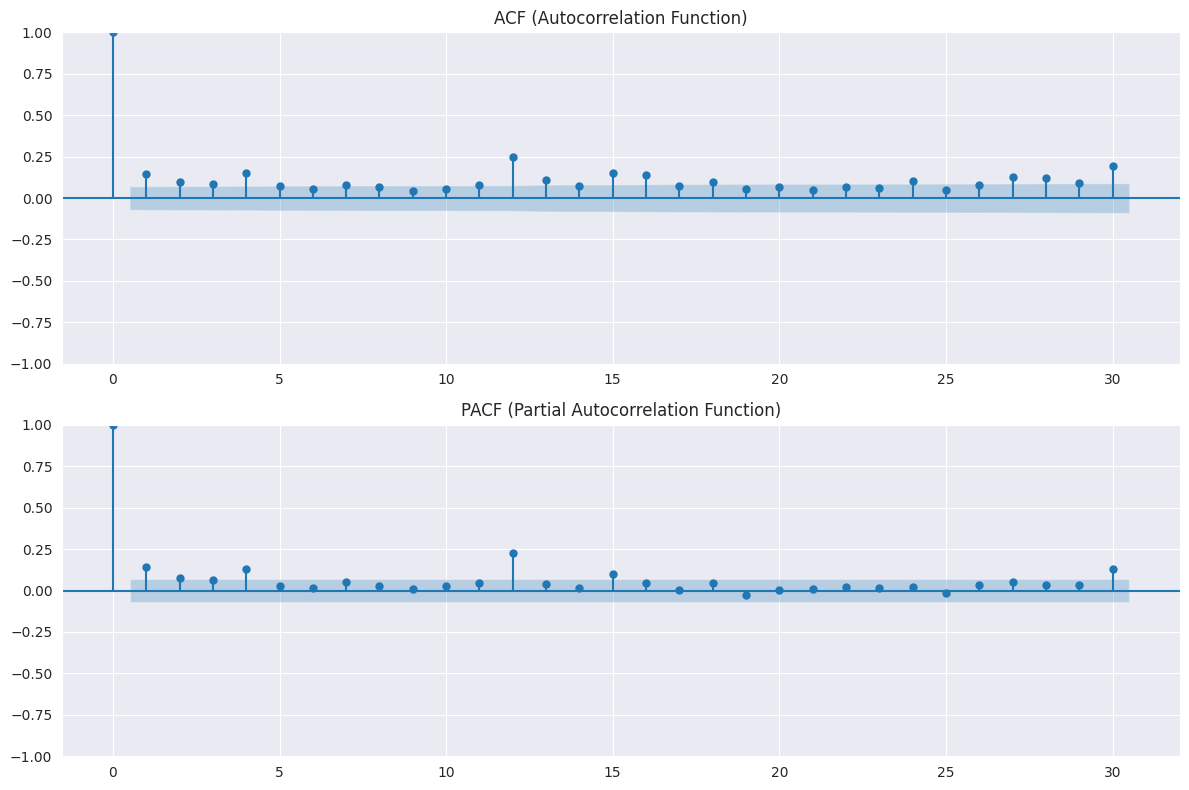

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF (Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_acf(time_series_data, lags=30, alpha=0.05, ax=ax1)  
ax1.set_title('ACF (Autocorrelation Function)')

# Plot PACF (Partial Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_pacf(time_series_data, lags=30, alpha=0.05, ax=ax2)  
ax2.set_title('PACF (Partial Autocorrelation Function)')

plt.tight_layout();

- From the ACF plot, the twelfth lag stands out the most, indicating a clear **seasonal pattern** that repeats **every 12 months**, as the data is monthly.
- Once again, the **twelfth** lag is the most prominent in the PACF plot.

Dataset dimensions: (766,)
Training data dimension: (612,) - 79.9% of dataset
Actual data dimension: (154,) - 20.1% of dataset


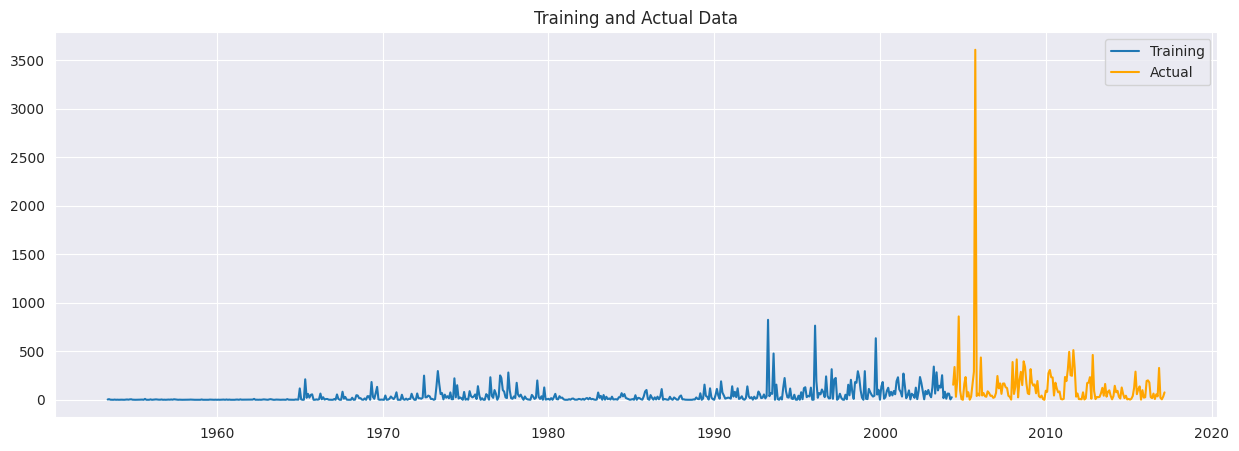

In [23]:
# Assign training and test subsets - 70:30 split 

print('Dataset dimensions:', time_series_data.shape)

# Split data
train_size = int(len(time_series_data) * 0.8)
train_data, test_data = time_series_data[:train_size], time_series_data[train_size:]

# Differencing the training data
train_data_diff = train_data.diff().dropna()

print(f"Training data dimension: {train_data.shape} - {round((len(train_data)/len(time_series_data)*100), 2)}% of dataset")
print(f"Actual data dimension: {test_data.shape} - {round((len(test_data)/len(time_series_data)*100), 2)}% of dataset")

# Plot training & test data 
plt.figure(figsize=(15, 5))
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Actual', color='orange')
plt.title("Training and Actual Data")
plt.legend()
plt.show()

In [24]:
# Recheck for strict stationarity.
adf_test(train_data_diff, regression='ct')
print() 
kpss_test(train_data_diff, regression='ct')

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -1.209900e+01
p-value                 2.667262e-19
Lags Used               1.300000e+01
Observations Used       5.970000e+02
Critical Value (1%)    -3.974015e+00
Critical Value (5%)    -3.417870e+00
Critical Value (10%)   -3.131392e+00
dtype: float64 

Reject H0: The series is stationary.


KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic            0.017318
p-value                   0.100000
Lags Used                17.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64 

Fail to Reject H0: The series is stationary.



/tmp/ipykernel_31453/1974365690.py:51: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries, regression=regression, nlags="auto")


# Auto ARIMA

In [37]:
# Train AUto ARIMA Model 
auto_arima_model = pm.auto_arima(train_data.values, X=None, 
                                 start_p=0, d=None, start_q=0, 
                                 max_p=5, max_d=2, max_q=5, 
                                 start_P=1, D=None, start_Q=1, 
                                 max_P=2, max_D=1, max_Q=2, 
                                 max_order=5, m=12, seasonal=True, 
                                 stationary=False, information_criterion='aic', 
                                 alpha=0.05, test='adf', seasonal_test='ocsb', 
                                 stepwise=True, n_jobs=1, start_params=None, 
                                 trend=None, method='lbfgs', maxiter=50, 
                                 offset_test_args=None, seasonal_test_args=None, 
                                 suppress_warnings=True, error_action='trace', 
                                 trace=True, random=False, random_state=23, 
                                 n_fits=50, return_valid_fits=False, out_of_sample_size=0, 
                                 scoring='mse', scoring_args=None, with_intercept='auto', 
                                 sarimax_kwargs=None)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=7018.631, Time=1.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7088.962, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7028.517, Time=0.87 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7038.807, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7226.315, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=7048.291, Time=0.52 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=7038.225, Time=0.72 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=7019.582, Time=4.34 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=7019.367, Time=3.69 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=7041.647, Time=1.21 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=7033.279, Time=1.91 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=5.30 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7012.559, Time=1.83 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7036.295, Time=0.85 sec
 ARIMA(1,0,0)(2,0,1)[12]

In [38]:
# Print the best model found
print(auto_arima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  612
Model:             SARIMAX(2, 0, 2)x(0, 0, [1], 12)   Log Likelihood               -3483.998
Date:                              Thu, 02 Jan 2025   AIC                           6979.996
Time:                                      17:44:48   BIC                           7006.496
Sample:                                           0   HQIC                          6990.303
                                              - 612                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0012      0.015      0.080      0.936      -0.028       0.030
ar.L2          0.99

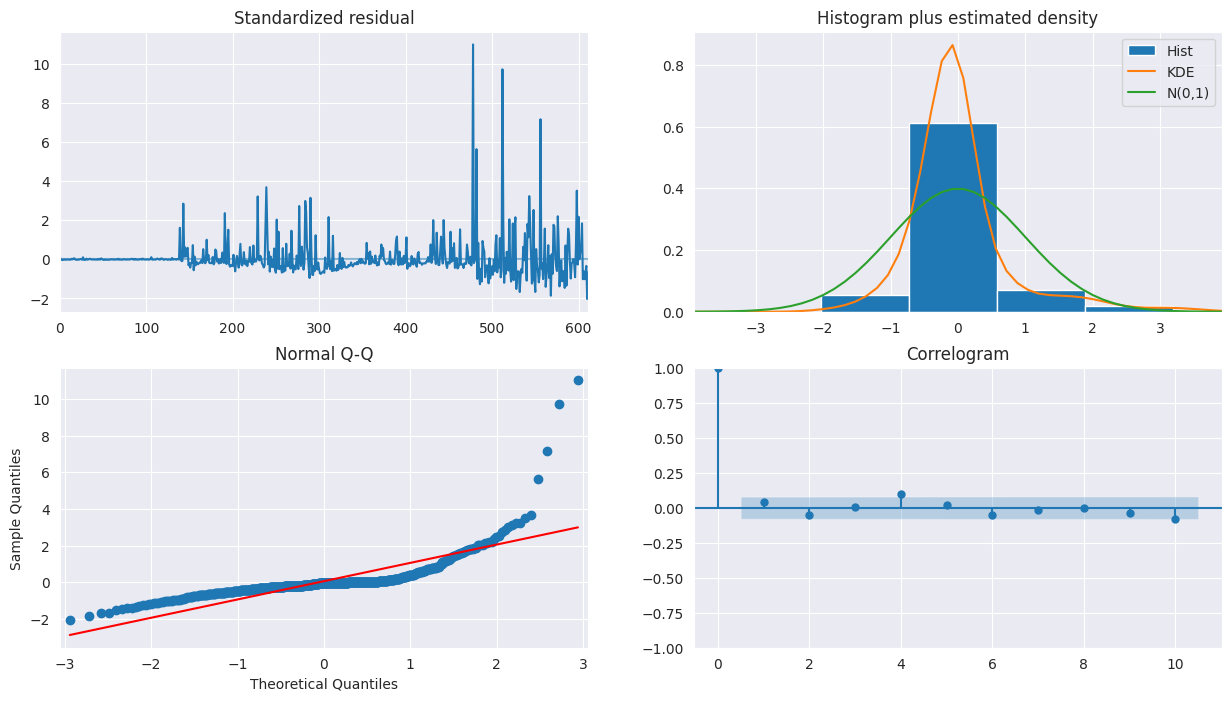

In [39]:
auto_arima_model.plot_diagnostics(figsize=(15, 8));

### Interpretation of plots in plot diagnostics

**Standardized residual:** The residual errors seem to to not fluctuate very well around a mean of zero and have a significant variance.

**Histogram:** The density plot suggest normal distribution.

**Theoretical Quantiles:** Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Correlogram:** The Correlogram (or ACF plot) examines autocorrelation in the residual errors:
- Since the autocorrelation coefficients fall outside the confidence interval, the residuals are autocorrelated, indicating that the model has not effectively captured the patterns in the data.
- Therefore, additional predictors (X variables) or further model adjustments may be necessary.

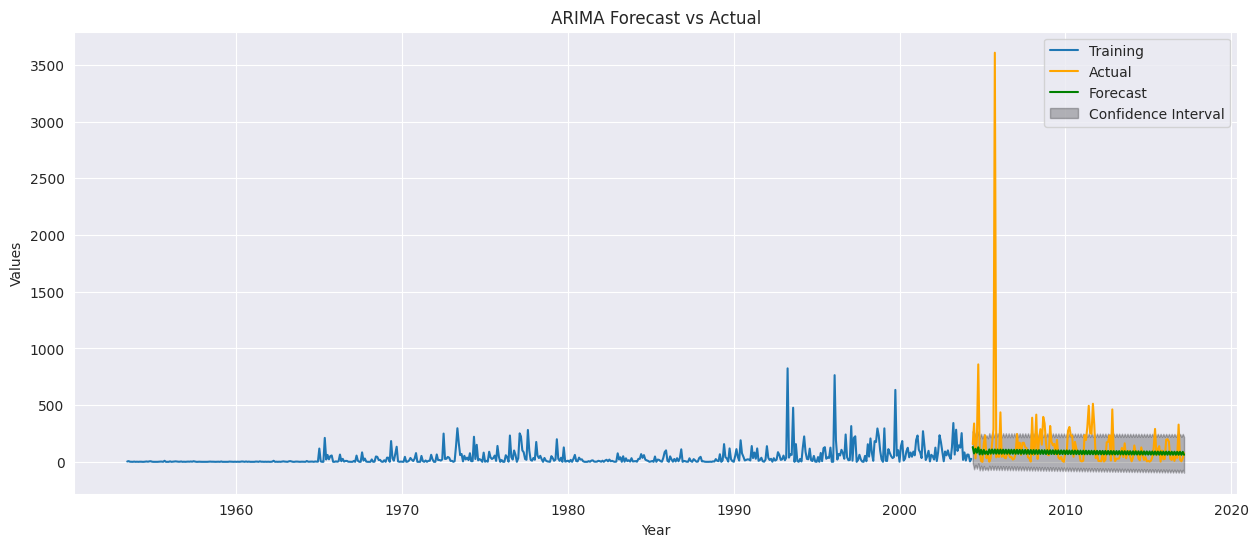

In [40]:
# Make predictions for the next n periods (Months)
n_periods = len(test_data)
forecast_auto_arima, confint = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Assuming time_series_data has a DatetimeIndex
start_date = train_data.index[-1]  # Get the last date from the training data
forecast_dates = pd.date_range(start=start_date, periods=n_periods + 1, freq='ME')[1:] 

# Make series for plotting purpose
forecast_series = pd.Series(forecast_auto_arima, index=forecast_dates)
lower_series = pd.Series(confint[:, 0], index=forecast_dates)
upper_series = pd.Series(confint[:, 1], index=forecast_dates)


# Plot training, test, and forecast data
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training')  
plt.plot(test_data, label='Actual', color='orange')  
plt.plot(forecast_series, label='Forecast', color='green')  
plt.fill_between(forecast_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.25, label='Confidence Interval')

plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.show()


In [41]:
# Accuracy metrics
def forecast_accuracy(actual, forecast):
    # Ensure the input arrays are numpy arrays
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Avoid division by zero by replacing actual values of 0 with a small number (e.g., 1e-10)
    small_value = 1e-6
    actual_safe = np.where(actual == 0, small_value, actual)

    # Calculate different accuracy metrics
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual_safe))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual_safe)   # MPE
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # RMSE

    return {
        'MAPE': mape,
        'ME': me,
        'MAE': mae,
        'MPE': mpe,
        'RMSE': rmse,
    }


In [42]:
###############
metrics_auto_arima = forecast_accuracy(test_data.values, forecast_auto_arima)

pd.DataFrame([metrics_auto_arima])

,MAPE,ME,MAE,MPE,RMSE
0,1.073325e+06,-57.943879,112.400061,1.073325e+06,311.660433


# ARIMA

In [ ]:
# Function to find the best p, d, q based on AIC 
def best_arima_order(time_series, p_range, d_range, q_range):
    best_aic = np.inf
    best_order = None
    best_model = None

    # Iterate over all combinations of p, d, q
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    # Fit SARIMA model
                    model = sm.tsa.SARIMAX(time_series, order=(p, d, q))
                    model_fit = model.fit(disp=False)

                    # Check AIC
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        best_model = model_fit
                        
                except Exception as e:
                    # Print or log the error if needed
                    print(f"Failed to fit ARIMA({p},{d},{q}): {e}")
                    continue

    return best_order, best_aic, best_model



# Set range for p, d, q
p_range = range(0, 6)  
d_range = range(0, 3)  
q_range = range(0, 6)  


# Find the best order
best_order, best_aic, best_model = best_arima_order(train_data_diff, p_range, d_range, q_range)


In [44]:
# Output the best parameters and AIC
print(f"Best ARIMA model order: {best_order}")
print(f"Best AIC: {best_aic}")

Best ARIMA model order: (3, 0, 4)
Best AIC: 6960.885252106352


The order of ARIMA should not be more than 10 summed up ($p + d + q \leq 10$)

In [ ]:
arima_model = sm.tsa.SARIMAX(train_data_diff, order=(3,0,4), seasonal_order=(3,0,4,12))
arima_model_fit = arima_model.fit(disp=False, maxiter=100)

In [47]:
# Forecasting and inverse differencing
forecast_arima = arima_model_fit.forecast(steps=len(test_data))

# Save the last original value from train_data
last_value = train_data.iloc[-1]

# Create the original scale forecasts
forecast_original = []
current_value = last_value

for diff in forecast_arima:
    current_value += diff
    forecast_original.append(current_value)

forecast_original = pd.Series(forecast_original, index=test_data.index)


# Get metrics
metrics_arima = forecast_accuracy(test_data.values, forecast_original)

# Convert the metrics dictionary to a DataFrame
metrics_arima_df = pd.DataFrame([metrics_arima])
metrics_arima_df

,MAPE,ME,MAE,MPE,RMSE
0,1.555552e+06,-47.097145,115.516011,1.555552e+06,314.69597


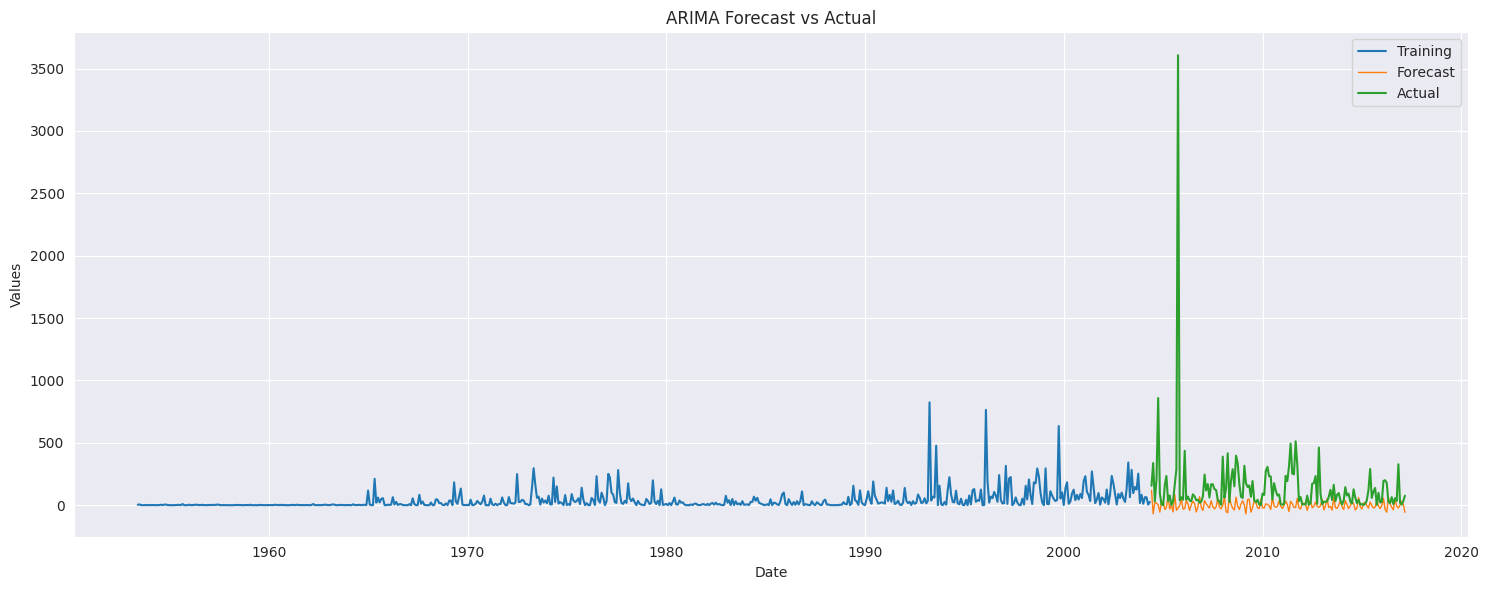

In [49]:
# Plot the original training data
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training')

# Plot the predicted data
plt.plot(test_data.index, forecast_arima, label='Forecast', linewidth=1)

# Optionally, plot the test data for comparison
plt.plot(test_data, label='Actual')

# Adding title and labels
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


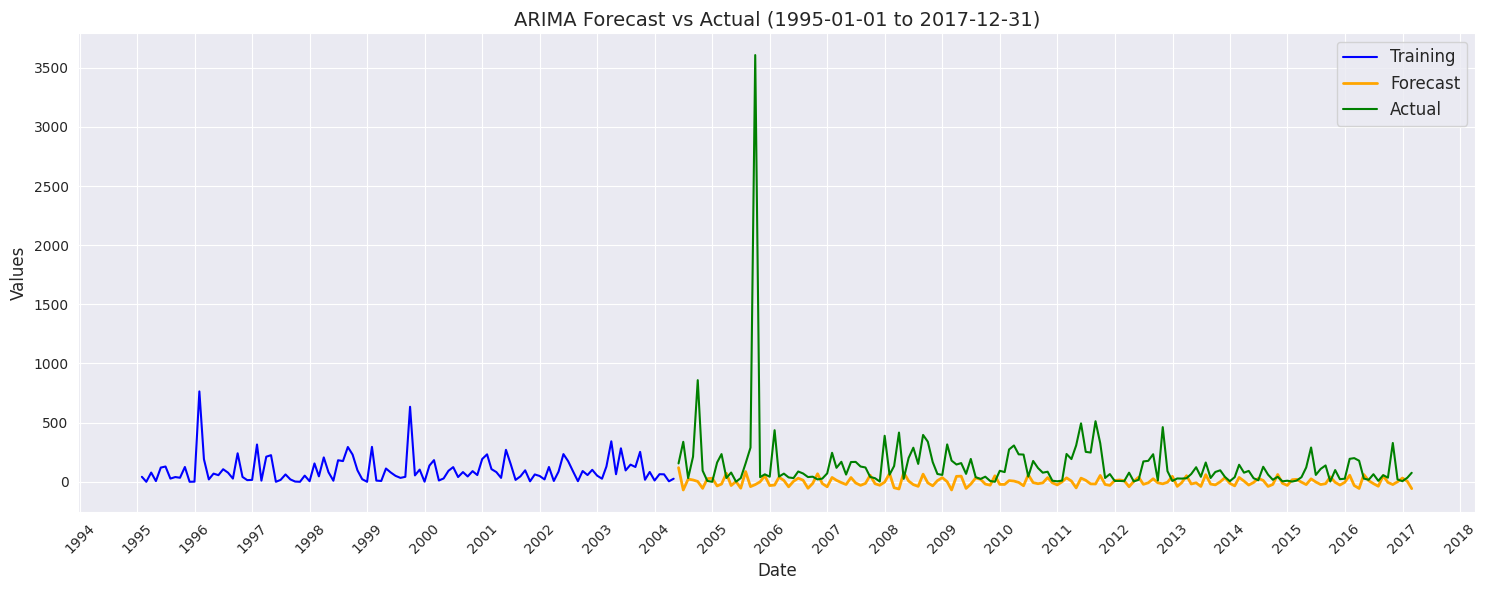

In [51]:
import matplotlib.dates as mdates

# Define the date range for the subset
start_date = '1995-01-01'
end_date = '2017-12-31'

# Slice the data for the specified date range
train_subset = train_data[start_date:end_date]
forecast_subset = forecast_arima[start_date:end_date]
test_subset = test_data[start_date:end_date]

# Plot the data
plt.figure(figsize=(15, 6))

# Plot the training data subset
plt.plot(train_subset, label='Training', color='blue')

# Plot the predicted data subset
plt.plot(forecast_subset.index, forecast_subset, label='Forecast', color='orange', linewidth=2)

# Plot the actual test data subset
plt.plot(test_subset, label='Actual', color='green')

# Add title and labels
plt.title(f"ARIMA Forecast vs Actual ({start_date} to {end_date})", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Format x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

# Rotate x-axis labels for clarity
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


# LSTM

The Long Short Term Memory (LSTM) is the advanced type of RNN, which was designed to prevent both decaying and exploding gradient problems. Just like RNN, LSTM has repeating modules, but the structure is different. Instead of having a single layer of tanh, LSTM has four interacting layers that communicate with each other. This four-layered structure helps LSTM retain long-term memory and can be used in several sequential problems including machine translation, speech synthesis, speech recognition, and handwriting recognition.

In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.random import set_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, GRU, Bidirectional


import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

set_seed(29)
np.random.seed(29)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*cuInit.*")

2025-01-02 17:50:55.621606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
disaster_counts_df.head()

,disaster_count
Declaration Date,
1953-05-31,3
1953-06-30,6
1953-07-31,1
1953-08-31,0
1953-09-30,0


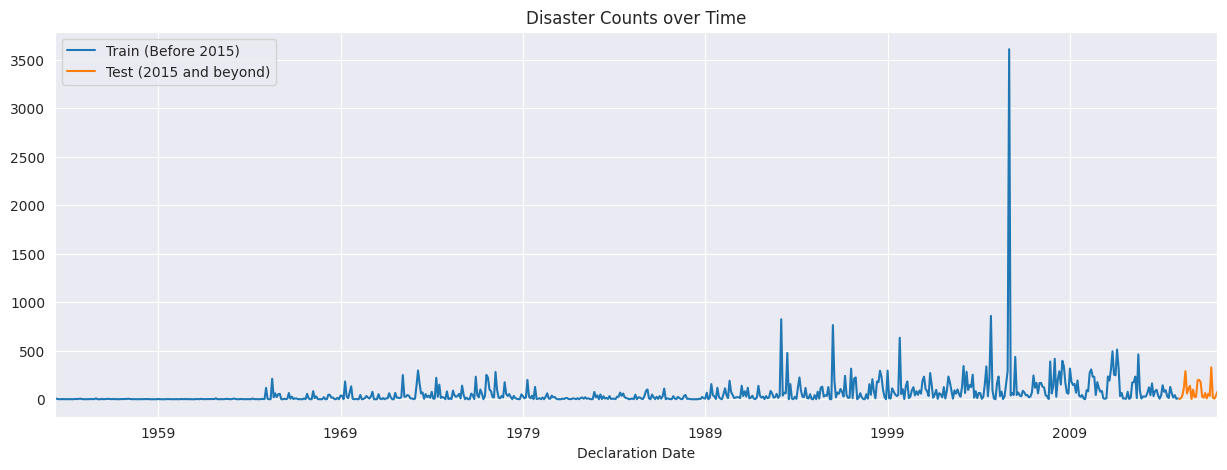

In [54]:
start_date = 1953
end_date = 2014

def train_test_plot(disaster_counts_df, start_date, end_date):
    disaster_counts_df.loc[f"{start_date}":f"{end_date}", "disaster_count"].plot(figsize=(15, 5), legend=True)
    disaster_counts_df.loc[f"{end_date+1}":, "disaster_count"].plot(figsize=(15, 5), legend=True)
    plt.legend([f"Train (Before {end_date+1})", f"Test ({end_date+1} and beyond)"])
    plt.title("Disaster Counts over Time");
    
    
    
train_test_plot(disaster_counts_df,start_date, end_date)


## Data Preprocessing

In [55]:
def train_test_split(dataset, tstart, tend):
    # Ensure that dataset's index is datetime for proper slicing
    dataset.index = pd.to_datetime(dataset.index)
    
    # Get the training set from tstart to tend (inclusive)
    train = dataset.loc[f"{tstart}-01-01":f"{tend}-12-31", "disaster_count"].values
    
    # Get the test set from tend+1 onwards (starting from January 1st of the next year)
    test = dataset.loc[f"{tend+1}-01-01":, "disaster_count"].values
    
    return train, test



def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [56]:
training_set, test_set = train_test_split(disaster_counts_df, start_date, end_date)

scaler = MinMaxScaler(feature_range=(0, 1))

training_set = training_set.reshape(-1, 1)
training_set_scaled = scaler.fit_transform(training_set)

# Split into supervised samples (X and y)
n_steps = 60
X_train, y_train = split_sequence(training_set_scaled,  n_steps)


"""  
We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model. 
The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].
"""

# Reshape input data to [samples, timesteps, features] for LSTM
timesteps = 1
X_train = X_train.reshape(X_train.shape[0], timesteps, X_train.shape[1])

inputs = disaster_counts_df[len(disaster_counts_df) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = scaler.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], timesteps, X_test.shape[1])

In [57]:
# Accuracy metrics
def forecast_metrics(actual, forecast):
    # Ensure the input arrays are numpy arrays
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Avoid division by zero by replacing actual values of 0 with a small number (e.g., 1e-10)
    small_value = 1e-6
    actual_safe = np.where(actual == 0, small_value, actual)

    # Calculate different accuracy metrics
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual_safe))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual_safe)   # MPE
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # RMSE

    return {
        'MAPE': mape,
        'ME': me,
        'MAE': mae,
        'MPE': mpe,
        'RMSE': rmse,
    }



def plot_loss_curves(history):
    # Extract loss values
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the loss curves
    plt.figure(figsize=(15, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();

#### LSTM Model

In [58]:
# Define the LSTM architecture
# lstm_model = Sequential([
#     Input(shape=(n_steps, 1)),  # Use Input layer for better practice
#     LSTM(units=125, activation="tanh"),
#     Dense(units=1)  # Output layer
# ])

lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  
    LSTM(units=125, activation="relu", return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(units=1)  
])


# Compile the model
lstm_model.compile(optimizer="RMSprop", loss="mse")

# Display the summary
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 125)         │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 125)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        90,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,501 (716.80 KB)

 Trainable params: 183,501 (716.80 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Fit the model with validation data
history_lstm = lstm_model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=8,
    validation_split=0.2, 
    verbose=1
)

Epoch 1/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.5027e-04 - val_loss: 0.0089
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3869e-04 - val_loss: 0.0089
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3815e-04 - val_loss: 0.0089
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3786e-04 - val_loss: 0.0089
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4046e-04 - val_loss: 0.0089
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3890e-04 - val_loss: 0.0089
Epoch 7/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3716e-04 - val_loss: 0.0089
Epoch 8/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3433e-04 - val_loss: 0.0089
Epoch 9/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3284e-04 - val_loss: 0.0088
Epoch 10/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3466e-04 - val_loss: 0.0089
Epoch 11/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3327e-04 - val_loss: 0.0089
Epoch 12/500
68/68 

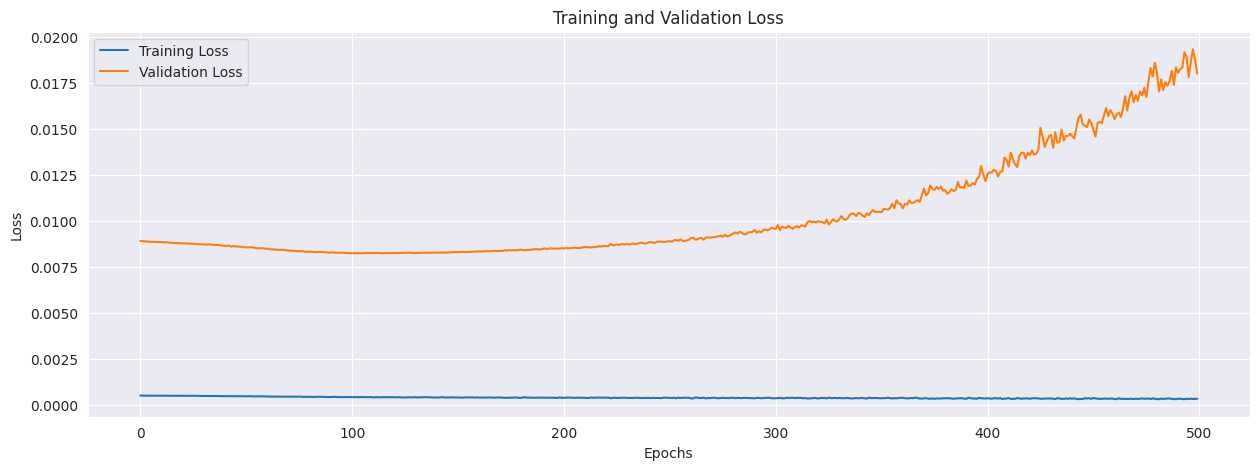

In [60]:
plot_loss_curves(history_lstm)

In [61]:
# Prediction
lstm_predicted_disaster = lstm_model.predict(X_test)
# Inverse transform the values
lstm_predicted_disaster = scaler.inverse_transform(lstm_predicted_disaster)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


In [62]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(15, 5))
    plt.plot(test, label="Actual")
    plt.plot(predicted, label="Predicted")
    plt.title("Disaster Prediction")
    plt.xlabel("Time")
    plt.ylabel("Disaster")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


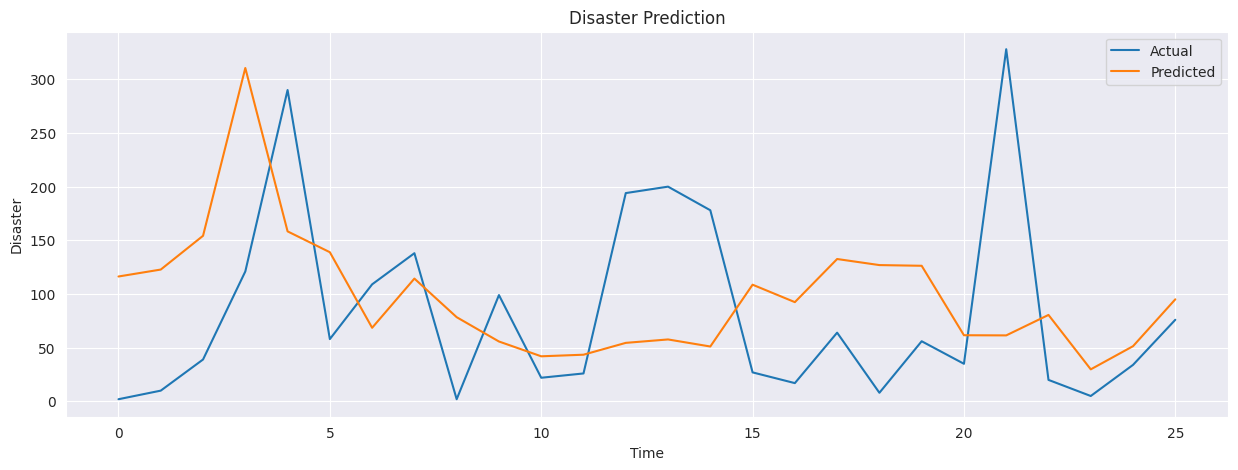

,MAPE,ME,MAE,MPE,RMSE
0,6.302772,14.446387,81.473216,5.968684,105.286313


In [63]:
plot_predictions(test_set, lstm_predicted_disaster)

metrics_lstm = forecast_metrics(test_set, lstm_predicted_disaster)

pd.DataFrame([metrics_lstm])

In [50]:
# MAPE	ME	MAE	MPE	RMSE
# 4.119509	-17.257666	65.726216	3.701432	89.743595

# MAPE	ME	MAE	MPE	RMSE
# 4.873017	-5.855571	68.385234	4.51683	88.249597

# New architecture
# MAPE	ME	MAE	MPE	RMSE
# 7.251038	28.085794	87.846332	6.944079	107.622367

# With RELU
# MAPE	ME	MAE	MPE	RMSE
# 7.419843	30.258371	91.035928	7.099446	112.740075

# GRU

The gated recurrent unit (GRU) is a variation of LSTM as both have design similarities, and in some cases, they produce similar results. GRU uses an update gate and reset gate to solve the vanishing gradient problem. These gates decide what information is important and pass it to the output. The gates can be trained to store information from long ago, without vanishing over time or removing irrelevant information.

Unlike LSTM, GRU does not have cell state $C_t$. It only has a hidden state $h_t$, and due to the simple architecture, GRU has a lower training time compared to LSTM models. The GRU architecture is easy to understand as it takes input $x_t$ and the hidden state from the previous timestamp $h_{t-1}$ and outputs the new hidden state $h_t$. 

In [64]:
# Define the GRU model
# gru_model = Sequential([
#     Input(shape=(n_steps, 1)),  
#     GRU(units=125, activation="tanh"),
#     Dense(units=1)
# ])

gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  
    GRU(units=125, activation="relu", return_sequences=True),
    Dropout(0.2),
    GRU(units=100, activation="tanh", return_sequences=False),
    Dropout(0.2),
    Dense(units=1) 
])



# Compile the model
gru_model.compile(optimizer="RMSprop", loss="mse")

# Display the summary
gru_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 125)         │        70,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 125)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        68,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,326 (540.34 KB)

 Trainable params: 138,326 (540.34 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)


# Fit the model with validation data
history_gru = gru_model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=2,
    validation_split=0.2, 
    verbose=1,
    shuffle=False, 
    callbacks=[early_stop]
)

Epoch 1/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.1618e-04 - val_loss: 0.0082
Epoch 2/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6921e-04 - val_loss: 0.0082
Epoch 3/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5639e-04 - val_loss: 0.0082
Epoch 4/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5511e-04 - val_loss: 0.0082
Epoch 5/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6122e-04 - val_loss: 0.0082
Epoch 6/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3381e-04 - val_loss: 0.0082
Epoch 7/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4837e-04 - val_loss: 0.0082
Epoch 8/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4260e-04 - val_loss: 0.0082
Epoch 9/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3028e-04 - val_loss: 0.0082
Epoch 10/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3865e-04 - val_loss: 0.0082
Epoch 11/500
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.3205e-04 - val_loss: 0.00

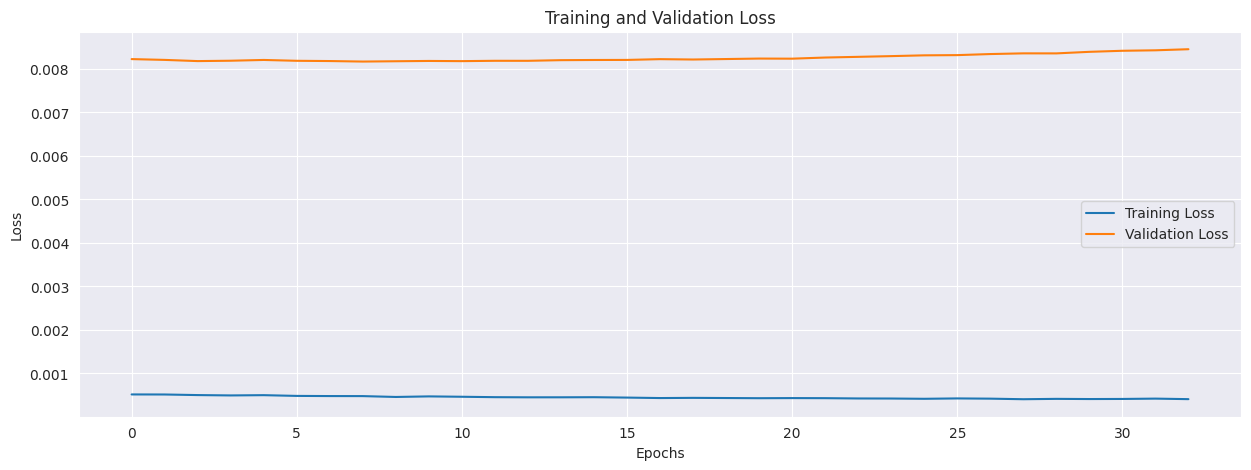

In [66]:
plot_loss_curves(history_gru)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


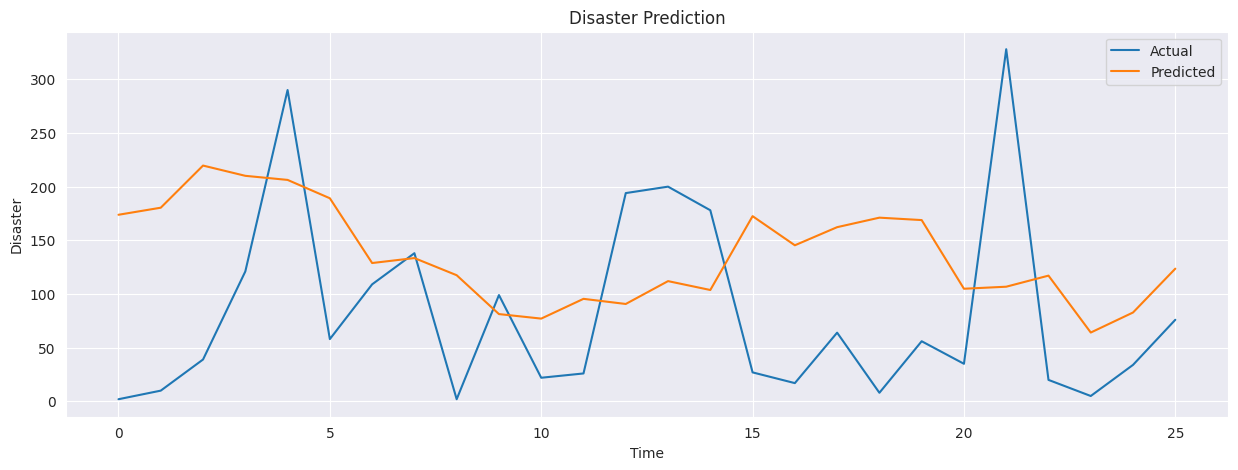

,MAPE,ME,MAE,MPE,RMSE
0,8.915509,53.113197,96.214665,8.733864,111.669991


In [67]:
gru_predicted_disaster = gru_model.predict(X_test)
gru_predicted_disaster = scaler.inverse_transform(gru_predicted_disaster)

plot_predictions(test_set, gru_predicted_disaster)

metrics_gru = forecast_metrics(test_set, gru_predicted_disaster)

pd.DataFrame([metrics_gru])

In [55]:
# MAPE	ME	MAE	MPE	RMSE
#	3.616012	-25.202713	65.199181	3.133258	92.237446
# MAPE	ME	MAE	MPE	RMSE
# 3.587264	-25.729234	65.409135	3.095605	92.6872

# New architecture
# MAPE	ME	MAE	MPE	RMSE
# 6.984635	22.974111	89.859568	6.578527	111.595037

# With RELU : best for now batch=32
# MAPE	ME	MAE	MPE	RMSE
# 7.017108	24.118958	89.742728	6.660399	114.842969